# Caltech-UCSD Birds-200-2011 (CUB) - Reader Writer class

## Imports

In [1]:
import numpy as np
import os
import csv
import cv2
import sys
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import pprint

## Globals

In [2]:
CUB_PATH = "../../CUB_200_2011/"
CSV_PATH = "cub_csv.csv"
PROCESS_CUB = True

## Helpers

In [3]:
# get row from csv file
def getCsvRow(csvData,rowNumber):
    return csvData[csvData.index == rowNumber]

# draw bounding box and clss title on csv row image
def draw_box(csvRow):
    for index, row in csvRow.iterrows():
        img = cv2.imread(row['filename'])
        img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 0), 1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img,row['class'],(row['xmin'],row['ymin']), font, 1,(0,0,0),1)
    return img

# read csv file
def getCsv(csvPath):
    csvData =  pd.read_csv(csvPath)
    #csvData.head()
    return csvData

# return first top items from dictionary
def head(d, top):
    return dict(list(d.items())[0:top-1])

## CUB to csv class

In [4]:
class CUB_ReadWrite:
    
    def __init__(self,cubPath):
        IMAGES_FILE   = "images.txt"
        BBOX_FILE     = "bounding_boxes.txt"
        IMGCLASS_FILE = "image_class_labels.txt"
        CLASSES_FILE  = "classes.txt"
        
        print(os.path.exists(cubPath))
        if (not (os.path.exists(cubPath))):
            raise ValueError("CUB data folder %s not found" % cubPath)
        else:
            self.cubPath = cubPath
            self.imgTxtPath = os.path.join(cubPath,IMAGES_FILE)
            print (self.imgTxtPath)
            self.bbTxtPath = os.path.join(cubPath,BBOX_FILE)
            self.imgClassPath = os.path.join(cubPath,IMGCLASS_FILE)
            self.classesPath = os.path.join(cubPath,CLASSES_FILE)
            if (not (os.path.exists(self.imgTxtPath) and os.path.exists(self.bbTxtPath) and os.path.exists(self.imgClassPath) \
                    and os.path.exists(self.classesPath) and os.path.exists(os.path.join(cubPath,'images')))):
                raise ValueError("a CUB data file not found ({} ,{} ,{}, {}, {})".format(self.imgTxtPath, self.bbTxtPath, \
                               self.imgClassPath, self.classesPath, 'images folder' ))
            else: 
                self.imgList,self.imgDict,self.imgSizesDict = self._readImgTxt()
                self.bboxDict = self._readBB()
                self.imgClassDict = self._readImgClass()
                self.classesDict = self._readClasses()
        
    def _getImgSize(self,imgPath):
        im = Image.open(imgPath)
        return im.size

    def _readImgTxt(self):
        imgList = []
        imgDict = {}
        imgSizesDict = {}
        with open(self.imgTxtPath) as f:
            spamreader = csv.reader(f, delimiter=' ')
            for row in spamreader:
                imgList.append(int(row[0]))
                imgPath = os.path.join(self.cubPath+'images',row[1])
                width,height = self._getImgSize(imgPath)
                imgDict[int(row[0])] = imgPath
                imgSizesDict[int(row[0])] = [width,height]
        return imgList,imgDict,imgSizesDict

    def _readBB(self):
        bboxDict = {}
        with open(self.bbTxtPath) as f:
            spamreader = csv.reader(f, delimiter=' ')
            for row in spamreader:
                bboxDict[int(row[0])] = [ int(float(x)) for x in row[1:5] ]
        return bboxDict

    def _readImgClass(self):
        imgClassDict = {}
        with open(self.imgClassPath) as f:
            spamreader = csv.reader(f, delimiter=' ')
            for row in spamreader:
                imgClassDict[int(row[0])] = int(row[1])  #offset by 0 
        return imgClassDict

    def _readClasses(self):
        classDict = {}
        with open(self.classesPath) as f:
            spamreader = csv.reader(f, delimiter=' ')
            for row in spamreader:
                classDict[int(row[0])] = row[1]
        return classDict
    
    def getImages(self):
        return self.imgDict
   
    def getImagesSizes(self):
        return self.imgSizesDict
    
    def getBoxes(self):
        return self.bboxDict
    
    def getImgClasses(self):
        return self.imgClassDict
    
    def getClasses(self):
        return self.classesDict
    
    def getCubSize(self):
        return len(self.imgList) , len(self.classesDict)    
    
    def writeCubToCsv(self,csvFilePath):
        with open(csvFilePath, 'w') as csvfile:
            fieldnames = ['filename', 'image-width', 'image-height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'centerx', 'centery', 'width', 'height' ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for k in self.imgList:
                i = k -1  # reindexing
                #imgPath = os.path.join(self.cubPath, self.imgDict[self.imgList[i]])
                imgPath  = self.imgDict[self.imgList[i]]
                imWidth  = self.imgSizesDict[self.imgList[i]][0]
                imHeight = self.imgSizesDict[self.imgList[i]][1] 
                imgClass = self.classesDict[self.imgClassDict[self.imgList[i]]]
                boxWidth = int(self.bboxDict[self.imgList[i]][2])
                boxHeight = int(self.bboxDict[self.imgList[i]][3])
                xmin = int(self.bboxDict[self.imgList[i]][0])
                ymin = int(self.bboxDict[self.imgList[i]][1])
                xmax = int(self.bboxDict[self.imgList[i]][0] + boxWidth)
                ymax = int(self.bboxDict[self.imgList[i]][1] + boxHeight)
                centerx = int(self.bboxDict[self.imgList[i]][0] + boxWidth / 2)
                centery = int(self.bboxDict[self.imgList[i]][1] + boxHeight / 2)
                writer.writerow({'filename' : imgPath,'image-width' : imWidth, 'image-height' : imHeight,'class' : imgClass,'xmin' : xmin,\
                     'ymin' : ymin,'xmax' : xmax,'ymax' : ymax, 'centerx' : centerx, 'centery' : centery, 'width' : boxWidth, 'height' : boxHeight})
    

## Usage sample
- init class object
 - print CUB data for debug
- write data into csv file
- read CUB csv file
 - debug print 10 lines header
- display sample image (by number) with bounding box and class as title

In [5]:

if (PROCESS_CUB):   # enables reloading the notebook wothout reading the data (csv read only)
    try:
        cub = CUB_ReadWrite(CUB_PATH)         # initialize class object cub
    except ValueError as e:
        print("error in class constructor: ",e)
        sys.exit()
    
    # this part is debug print only of the class methods returned data 
    # ---------------------------------------------------------------------------------------------------
    print(cub.getCubSize())                      # CUB records (int)
    pprint.pprint(head(cub.getImages(),10))      # images path (dict - {id : path})
    pprint.pprint(head(cub.getImagesSizes(),10)) # images sizes (dict - {id : [width,height]})
    pprint.pprint(head(cub.getImgClasses(),10))  # images class id (dict - {id : class id} )
    pprint.pprint(head(cub.getBoxes(),10))       # images boxes(dict - {id : [xmin, ymin, width, height]})
    pprint.pprint(head(cub.getClasses(),10))     # CUB class names (dict - {id : class name})
    
    # --------------------------------------------------------------------------------------------------
    
    cub.writeCubToCsv(CSV_PATH)           # write to csv file
    del(cub)                              # delete cub object
    

True
../../CUB_200_2011/images.txt
(11788, 200)
{1: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg',
 2: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg',
 3: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg',
 4: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg',
 5: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg',
 6: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg',
 7: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0031_100.jpg',
 8: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg',
 9: '../../CUB_200_2011/images\\001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg'}
{1: [500, 335],
 2: [500, 336],
 3: [500, 347],
 4: [415, 500],
 5: [331, 380],

In [6]:
csvData = getCsv(CSV_PATH)    # read csv file into csvData object
csvData.head(10)              # show first 10 lines

filename  image-width  \
0  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
1  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
2  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
3  ../../CUB_200_2011/images\001.Black_footed_Alb...          415   
4  ../../CUB_200_2011/images\001.Black_footed_Alb...          331   
5  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
6  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
7  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
8  ../../CUB_200_2011/images\001.Black_footed_Alb...          500   
9  ../../CUB_200_2011/images\001.Black_footed_Alb...          250   

   image-height                       class  xmin  ymin  xmax  ymax  centerx  \
0           335  001.Black_footed_Albatross    60    27   385   331      222   
1           336  001.Black_footed_Albatross   139    30   292   294      215   
2           347  001.Black_footed_Albatross    14   112   402   298      208   
3           500  001.Black_footed_Albatross   112    90   367   332      239   
4           380  001.Black_footed_Albatross    70    50   204   353      137   
5           470  001.Black_footed_Albatross    33    53   284   448      158   
6           340  001.Black_footed_Albatross     7    75   427   337      217   
7           391  001.Black_footed_Albatross    78    86   411   244      244   
8           416  001.Black_footed_Albatross   112    76   333   265      222   
9           208  001.Black_footed_Albatross    27     4   226   205      126   

   centery  width  height  
0      179    325     304  
1      162    153     264  
2      205    388     186  
3      211    255     242  
4      201    134     303  
5      250    251     395  
6      206    420     262  
7      165    333     158  
8      170    221     189  
9      104    199     201

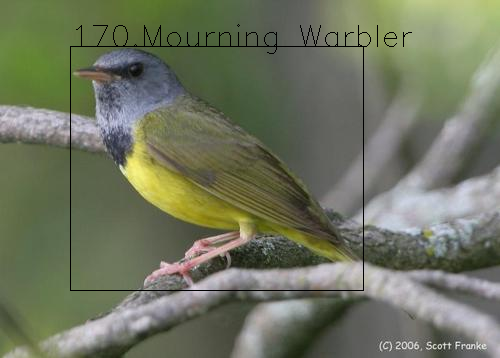

In [7]:
# show image by number including bounding box and class as title
imgNum = 10000
csvRow= getCsvRow(csvData,imgNum)
pilImage = Image.fromarray(cv2.cvtColor(draw_box(csvRow),cv2.COLOR_BGR2RGB))
pilImage

In [8]:
# open image in external image viewer
pilImage.show()